### 02 LangGraph/LangChain によるLLMチャット（Ollama）
- Google Colab に Ollama をセットアップ
- ChatOllama で LLM に接続
- LangGraph によるLLMのメモリ管理
- LangGraph/LangChain によるチャット
- MCPサーバ（ddg-search）によるweb検索（今回（notebook 02）はユーザがMCPサーバを実行）

**Google Colab に Ollama をセットアップ**
- Ollama のインストール, 起動, モデルのダウンロードを行う。
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [1]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)

!ollama pull gemma3:1b-it-qat > /dev/null 2>&1 && echo "Done!"
!ollama show gemma3:1b-it-qat

Selecting previously unselected package zstd.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Done!
  Model
    architecture        gemma3     
    parameters          999.89M    
    context length      32768      
    embedding length    1152       
    quantization        Q4_0       

  Capabilities
    completion    

  Parameters
    stop           "<end_

**必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後からインストールしたパッケージが優先され、依存関係が壊れるリスクがある。
- NOTE: Colab では uv ではなく pip を使う。
> uv は依存解決の過程で numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [2]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
%pip install -U langchain-ollama langgraph \
     duckduckgo-mcp-server mcp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.7
    Uninstalling langgraph-1.0.7:
      Successfully uninstalled langgraph-1.0.7


**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [3]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gemma3:1b-it-qat",
    num_ctx=4096,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning=None,
)

**LangGraph によるLLMのメモリ管理**
- chat_node で、LLM を呼び出した際の処理を設定。
> 今回は人間のプロンプトを LLM に入力して、LLM から応答を取得する処理。
- LangGraph のグラフを構築し、ノードとエッジを設定し、グラフを compile する。
> 今回は単純だが、各処理をつなげて自動化させる場合に効果を発揮する。
- InMemorySaver を使用して、LLM との会話をメモリに保存させる。
> LLM とのチャット履歴が保持されるようになる。
- 作成したグラフを図示する。

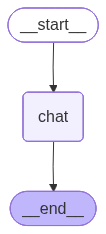

In [4]:
# LangGraph によるメモリ付きチャットグラフの構築
# InMemorySaver を使って、スレッド（thread_id）ごとに会話履歴を保持する
from langgraph.graph import StateGraph, MessagesState, START, END  # type: ignore
from langgraph.checkpoint.memory import InMemorySaver  # type: ignore
from IPython.display import Image, display


# チャットノード：現在の会話履歴を LLM に送信し、返答を生成
def chat_node(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


# グラフの構築
graph = StateGraph(MessagesState)
graph.add_node("chat", chat_node)
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# InMemorySaver：スレッドごとに会話履歴をインメモリで保持
memory = InMemorySaver()
app = graph.compile(checkpointer=memory)

# 構築したグラフを図示
display(Image(app.get_graph().draw_mermaid_png()))

**LangGraph/LangChain によるチャット**
- SystemMessage でシステムプロンプトを、HumanMessage でユーザのプロンプトを設定する。
- config で指定した thread_id ごとに会話履歴が保持される。
- 2回目の質問で前の会話を踏まえた回答が返れば、メモリが正常に動作している証拠。

In [5]:
# マルチターン会話のテスト
# 同じ thread_id で LLM を複数回呼び出すと、会話履歴が自動的に保持される
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

config = {"configurable": {"thread_id": "thread_1"}}

# 1回目の質問（システムプロンプト付き）
response1 = app.invoke(
    {
        "messages": [
            SystemMessage(content="日本語で回答してください。"),
            HumanMessage(content="私はジョンです。日本で一番高い山は？"),
        ]
    },
    config=config,
)
print("=== 1回目の返答 ===")
print(response1["messages"][-1].content)

# 2回目の質問（前の会話を踏まえて回答できれば、メモリが動作している証拠）
response2 = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="私の名前は何ですか？先ほど答えた山の高さは何メートルですか？"
            ),
        ]
    },
    config=config,
)
print("\n=== 2回目の返答 ===")
print(response2["messages"][-1].content)

=== 1回目の返答 ===
日本で一番高い山は、**富士山**です！

富士山は、標高930.4m で、日本最高峰です。

何か他に知りたいことはありますか？

=== 2回目の返答 ===
あなたの名前はジョンです。

富士山は標高930.4mです。


**MCPサーバ（duckduckgo-mcp-server）によるWeb検索**
- MCPサーバ（duckduckgo-mcp-server）を stdio 経由で起動し、検索ツールを取得する。
> AIに自律的に検索ツールを使わせるのではなく、今回（notebook 02）はユーザがMCPサーバを実行。
- 検索結果をコンテキストとして LLM に渡し、回答を生成させる。

**MCPサーバ設定の補足**

github に記載されているMCP接続の設定は以下
> "mcpServers": {"ddg-search": {"command": "uvx", "args": ["duckduckgo-mcp-server"]}}

今回は、pip install済なので、command="duckduckgo-mcp-server" で直接起動。uvx経由ではないので、args=[] としてよい。

**stdio_client接続の補足**

async with stdio_client(server_params) as (read, write):を、次に修正している。
> async with stdio_client(server_params, errlog=open(os.devnull, "w")) as (read, write):

これはColab環境特有の処置で、Colabの内部構造が標準的なstderrに対応していないため。

In [6]:
# MCPサーバ（duckduckgo-mcp-server）に接続して検索し、結果をLLMに渡す
# Colab環境ではasyncioのインポートなしで非同期処理（async/await）が使用可能
# 通常のPython環境では、asyncioのインポートが必要
import os
from mcp import ClientSession, StdioServerParameters  # type: ignore
from mcp.client.stdio import stdio_client  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

# MCPサーバへの接続パラメータ（stdio 経由で起動）
server_params = StdioServerParameters(
    command="duckduckgo-mcp-server",
    args=[],
)

query = "2025年 日本の総人口"

# MCPサーバに接続し、検索ツールを取得して実行
# NOTE: Colab の stderr は fileno() 未対応のため、errlog をファイルに迂回する
async with stdio_client(server_params, errlog=open(os.devnull, "w")) as (read, write):
    async with ClientSession(read, write) as session:
        await session.initialize()

        # MCPサーバが提供するツール一覧を表示
        tools = await session.list_tools()
        print("=== 利用可能なツール ===")
        for t in tools.tools:
            print(f"  - {t.name}: {t.description}")

        # 検索ツールを実行（max_results で検索結果数を制限）
        result = await session.call_tool("search", {"query": query, "max_results": 3})

# 検索結果を取得
search_results = result.content[0].text
print("\n=== 検索結果 ===")
print(search_results)

# 検索結果をコンテキストとしてLLMに質問
config = {"configurable": {"thread_id": "thread_search"}}
response = app.invoke(
    {
        "messages": [
            SystemMessage(
                content="以下の検索結果をもとに、ユーザの質問に日本語で簡潔に回答してください。"
            ),
            HumanMessage(content=f"質問: {query}\n\n検索結果:\n{search_results}"),
        ]
    },
    config=config,
)
print("\n=== LLMの回答 ===")
print(response["messages"][-1].content)

=== 利用可能なツール ===
  - search: 
    Search DuckDuckGo and return formatted results.

    Args:
        query: The search query string
        max_results: Maximum number of results to return (default: 10)
        ctx: MCP context for logging
    
  - fetch_content: 
    Fetch and parse content from a webpage URL.

    Args:
        url: The webpage URL to fetch content from
        ctx: MCP context for logging
    

=== 検索結果 ===
Found 3 search results:

1. 人口推計（2025年（令和7年）8月確定値、2026年（令和8年）1月概算値） （2026年1月20日公表）
   URL: https://www.stat.go.jp/data/jinsui/new.html
   Summary: 2026年（令和8年）1月報 （2025年（令和7年）8月確定値、2026年（令和8年）1月概算値）（PDF：346KB） 統計表 統計表 （政府統計の総合窓口「e-Stat」 掲載の統計表） ※ その他の推計結果 各月1日現在人口 「全国：年齢（5歳階級）、男女別人口」 各年10月1日現在人口 「全国：年齢（各歳）、男女別 ...

2. 日本の人口・男女年齢階級別2025年 - Memorva メモルヴァ
   URL: https://memorva.jp/ranking/japan/soumu_population_age.php
   Summary: 2025年8月6日、総務省が発表した「住民基本台帳に基づく人口、人口動態及び世帯数」によると、2025年（令和7年）1月1日現在の日本の総人口は1億2,433万690人だった。 前年から55万4,485人減少した。

3. 2025年の日本人の人口は1億2065万3227人